In [29]:
import numpy as np    
import pandas as pd    
import plotly.express as px
import matplotlib.pyplot as plt  
import os  
import cartopy.crs as ccrs  
import cartopy.feature as cfeature  
import matplotlib.ticker as mticker
from dask.array.overlap import nearest
from matplotlib.ticker import MultipleLocator, FuncFormatter
import xarray as xr

In [52]:
df = xr.open_dataset(r'../data/WOA_2023/1965-Now_Annual_si/1_woa23_all_i00_01.nc', decode_times=False)
df = df.sel(depth=4000,time=3894, method='nearest')
df = df.rename({'i_an':'si'})
df

<xarray.Dataset>
Dimensions:  (lat: 31, lon: 41)
Coordinates:
    time     float32 3.894e+03
    depth    float32 4e+03
  * lat      (lat) float32 -4.5 -3.5 -2.5 -1.5 -0.5 ... 21.5 22.5 23.5 24.5 25.5
  * lon      (lon) float32 125.5 126.5 127.5 128.5 ... 162.5 163.5 164.5 165.5
Data variables:
    si       (lat, lon) float32 ...
    crs      int32 ...
Attributes: (12/46)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : moles_of_silica...
    summary:                         
    references:                      Cross, S.L., H.E. Garcia, C. Bouchard, C...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2023-09-30 
    date_modified:                   2023-09-30 
    History:                         Translated to CF-1.0 Conventions by Netc...

In [3]:
df_2024 = pd.read_excel('../../../ze_1112/最新数据/NORC2022-09_Chl-a+营养盐_20240422更新_绘图使用数据.xls')
# df.dropna(inplace=True)
df_2024 = df_2024.rename(columns={'站位':'站位名'})
df_2021 = pd.read_excel('../../all_draw/CTD/营养盐数据.xlsx')
df_2021['站位'] = df_2021['站位'].ffill()
df_2021 = df_2021.rename(columns={'站位':'站位名'})

In [4]:
stations_2021 = []
for i in df_2021['站位名']:
    stations_2021.append(i)
stations_2021 = list(set(stations_2021))
print(stations_2021)
stations_2024 = []
for i in df_2024['站位名']:
    stations_2024.append(i)
stations_2024 = list(set(stations_2024))
print(stations_2024)

['E142-5', 'E163-02', 'E163-11', 'QB08', 'QB16', 'E163-07', 'QB01', 'QB14', 'QB03', 'E163-06', 'QB-07new', 'QB04', 'QB15', 'N3-03', 'E142-07', 'QB06', 'QB09', 'N3-05', 'QB10', 'E163-10', nan, 'EQ-03', 'E142-06', 'E142-10', 'QB02', 'QB07', 'FB01', 'QB18', 'QB19', 'QB11', 'FB02', 'E163-03', 'N3-01', 'E163-08', 'QB05', 'E163-05', 'E163-09', 'E163-04', 'Mk-03', 'E163-01', 'QB17', 'QB12']
['E163-02', 'N21-13', 'E163-06s', 'QB08', 'N21-11', 'E163-07', 'E140-03orQB01', 'QB03', 'E163-06', 'QB04', 'E130-04', 'E140-08', 'N21-14', 'N21-10', 'QB06', 'N03-02', 'E130-05', 'N03-04', 'N03-03', 'E130-12', 'E130-14', 'E163-04s', 'QB07', 'FB01', 'E130-11', 'E130-08', 'E163-03', 'E163-05', 'E130-13', 'E130-03', 'E130-06', 'E163-04', 'E140-11', 'E140-07', 'N21-12', 'E130-02', 'E163-01', 'E130-10', 'E130-09', 'E130-07']


In [5]:
import re

def dms_to_decimal(dms):
    # 使用正则表达式匹配度分秒格式，包括不同的分隔符和方向指示符
    match = re.match(r"(\d+)[°\s](\d+)[′'’\s](\d+(\.\d+)?)[\"\s]?(N|S|E|W)?", dms)
    if match:
        degrees = float(match.group(1))
        minutes = float(match.group(2))
        seconds = float(match.group(3))
        direction = match.group(5)
        decimal = degrees + (minutes / 60) + (seconds / 3600)
        if direction in ['S', 'W']:
            decimal = -decimal
        return decimal
    else:
        raise ValueError(f"无法解析的度分秒格式: {dms}")

# 自定义刻度格式化函数
def lon_formatter(x, pos):
    if x < 0:
        return f'{abs(int(x))}°W'
    elif x > 180:
        return f'{360-int(x)}°W'
    else:
        return f'{int(x)}°E'

def lat_formatter(x, pos):
    if x > 0:
        return f'{int(x)}°N' 
    else:
        return f'{int(x)}°S'

def dms_to_decimal_2024(dms):
    """将度分秒转换为十进制度数"""
    dms = dms.replace('°', ' ').replace('′', ' ').replace('″', ' ').replace('"E', ' ').replace('"N', ' ').replace('"S', ' ')
    parts = dms.split()
    degrees = float(parts[0])
    minutes = float(parts[1]) if len(parts) > 1 else 0
    seconds = float(parts[2]) if len(parts) > 2 else 0
    decimal = degrees + (minutes / 60) + (seconds / 3600)
    return decimal

In [6]:
stations_ctd_2024 = os.listdir(r'D:\ze_1112\最新数据\CTD补上溶解氧_04共享航次计划调查资料汇交表')
lonlat = []  
for i in stations_ctd_2024:
    if i.endswith('.xls'):
        df = pd.read_excel(r'D:\ze_1112\最新数据\CTD补上溶解氧_04共享航次计划调查资料汇交表\%s' % i, skiprows=1, header=1)
        df = df.drop(0)
        longitude = df['经度'].apply(dms_to_decimal_2024).values # type: ignore
        latitude = df['纬度'].apply(dms_to_decimal_2024).values  # type: ignore
        name = df['站位名'].values
        lonlat.append((longitude[3], latitude[3], name[3]))
lonlat = pd.DataFrame(lonlat, columns=['lon', 'lat', '站位名'])
data_path_2024 = pd.merge( lonlat, df_2024, on='站位名')

In [7]:
stations_ctd_2021 = os.listdir(r'../CTD/CTD')
lonlat = []  
for i in stations_ctd_2021:
    if i.endswith('.xls'):
        df = pd.read_excel(r'../CTD/CTD/%s' % i, skiprows=1, header=1)
        df = df.drop(0)
        longitude = df['经度'].apply(dms_to_decimal).values # type: ignore
        latitude = df['纬度'].apply(dms_to_decimal).values  # type: ignore
        name = df['站位名'].values
        lonlat.append((longitude[3], latitude[3], name[3]))
lonlat = pd.DataFrame(lonlat, columns=['lon', 'lat', '站位名'])
data_path_2021 = pd.merge( lonlat, df_2021, on='站位名')

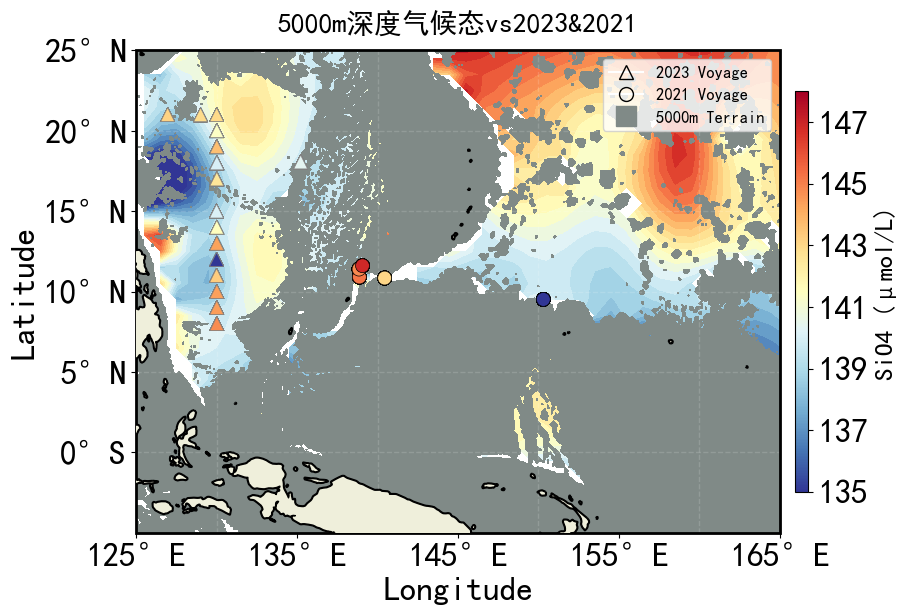

In [47]:
#####################################绘制scatter###############################################
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = 24

longitude_q = df['lon'].values
latitude_q = df['lat'].values
sio4_q = df['si'].values

stations_path_2021 = []
for i in data_path_2021['站位名']:
    stations_path_2021.append(i)
stations_path_2021 = list(set(stations_path_2021))

stations_path_2024 = []
for i in data_path_2024['站位名']:
    stations_path_2024.append(i)
stations_path_2024 = list(set(stations_path_2024))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(),facecolor='white')
ax.set_extent([135, 165.001, -5, 20.001], crs=ccrs.PlateCarree())
ax.contourf(longitude_q, latitude_q, sio4_q, levels=50, cmap='RdYlBu_r', transform=ccrs.PlateCarree(), vmin=135, vmax=148)
for station_path_2021 in stations_path_2021:
    data = data_path_2021[data_path_2021['站位名'] == station_path_2021]
    max_depth = data['深度(m)'].max()
    data_2021 = data_path_2021[(data_path_2021['深度(m)'] >= 4800) & (data_path_2021['深度(m)'] <= 5200)]
    # data_2021 = data_path_2021[data_path_2021['深度(m)'] == 3000]##########################################################################################
    station = data_2021['站位名']
    lon = data_2021['lon'].values
    lat = data_2021['lat'].values
    sio4_2021 = data_2021['硅酸盐'].values
    sc = ax.scatter(lon, lat, s=100, c=sio4_2021, cmap='RdYlBu_r', marker='o', alpha=1, edgecolors='k', transform=ccrs.PlateCarree(), zorder=10, linewidths=0.5, vmin=135, vmax=148)

for station_path_2024 in stations_path_2024:
    data = data_path_2024[data_path_2024['站位名'] == station_path_2024]
    max_depth = data['水深（m）'].max()
    data_2024 = data_path_2024[(data_path_2024['水深（m）'] >= 4800) & (data_path_2024['水深（m）'] <= 5200)]
    # data_2024 = data_path_2024[data_path_2024['水深（m）'] == 3000]##########################################################################################
    station = data_2024['站位名']
    long = data_2024['lon'].values
    lati = data_2024['lat'].values
    sio4_2024 = data_2024['SiO4-Si  (μmol/L)'].values
    sc2 = ax.scatter(long, lati, s=100, c=sio4_2024, cmap='RdYlBu_r', marker='^', alpha=1, edgecolors='gray', transform=ccrs.PlateCarree(), zorder=10, linewidths=0.5, vmin=135, vmax=148)
    
ax.spines[:].set_linewidth(2)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.COASTLINE, linewidth=2)
ax.add_feature(cfeature.RIVERS, linewidth=2)
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=9)
#####################################################
import xarray as xr
ds = xr.open_dataset(r"..\data\Copernicus_bathy\cmems_mod_glo_phy_my_0.083deg_static_1720691864705.nc")
elevation = ds['deptho'].values
longitude = ds['longitude'].values
latitude = ds['latitude'].values
mask = elevation > 4000 ##################################################################################################
mask_1 = elevation > 2000
mask_2 = elevation > 5000
# zhe_gai = ax.contourf(longitude, latitude, mask, levels=[0, 0.5], colors='#C0C0C0', transform=ccrs.PlateCarree(), alpha = 1)
zhe_gai_2 = ax.contourf(longitude, latitude, mask_2, levels=[0, 0.5], colors='#808A87', transform=ccrs.PlateCarree(), alpha = 1)
# zhe_gai_1 = ax.contourf(longitude, latitude, mask_1, levels=[0, 0.5], colors='#E3A869', transform=ccrs.PlateCarree(), alpha = 0.8)
######################################################
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
gl = ax.gridlines(draw_labels=False, linewidth=1, color='white', alpha=0.15, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
ax.set_xticks(np.arange(125, 165.001, 10))
ax.set_yticks(np.arange(0, 25.001, 5))
ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))  
    
cbar = plt.colorbar(sc2, ax=ax, orientation='vertical', pad=0.02, aspect=30, shrink=0.65)
cbar.set_label('SiO4 (μmol/L)', fontsize=18)
cbar.set_ticks(np.arange(135,148,2))
cbar.set_ticklabels(['135', '137', '139', '141', '143', '145', '147'])
# 添加图例
from matplotlib.lines import Line2D
# legend_elements = [Line2D([0], [0], marker='o', color='w', label='2021年数据',
#                           markerfacecolor='none', markeredgecolor='k', markersize=10),
#                    Line2D([0], [0], marker='^', color='w', label='2024年数据',
#                           markerfacecolor='none', markeredgecolor='k', markersize=10)]
legend_elements = [Line2D([0], [0], marker='^', color='w', label='2023 Voyage',
                          markerfacecolor='none', markeredgecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='2021 Voyage',
                          markerfacecolor='none', markeredgecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='#808A87', label='5000m Terrain',markersize=14, linestyle='none')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12,framealpha=0.8, fancybox=True)
ax.set_title('5000m深度气候态vs2023&2021', fontsize=20, y=1.02)

plt.show()
# plt.savefig('2023vs2021vsClimaticState_5000m.png', bbox_inches='tight', dpi=300)
plt.close()         

In [53]:
#####################################绘制scatter###############################################
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = 24

#####################
selected_depth = 4000
#####################

longitude_q = df['lon'].values
latitude_q = df['lat'].values
sio4_q = df['si'].values

stations_path_2021 = []
for i in data_path_2021['站位名']:
    stations_path_2021.append(i)
stations_path_2021 = list(set(stations_path_2021))

stations_path_2024 = []
for i in data_path_2024['站位名']:
    stations_path_2024.append(i)
stations_path_2024 = list(set(stations_path_2024))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), facecolor='white')
ax.set_extent([135, 165.001, -5, 20.001], crs=ccrs.PlateCarree())
ax.contourf(longitude_q, latitude_q, sio4_q, levels=50, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
for station_path_2021 in stations_path_2021:
    data = data_path_2021[data_path_2021['站位名'] == station_path_2021]
    max_depth = data['深度(m)'].max()
    # data_2021 = data_path_2021[(data_path_2021['深度(m)'] >= 4800) & (data_path_2021['深度(m)'] <= 5200)]
    data_2021 = data_path_2021[data_path_2021['深度(m)'] == selected_depth]##########################################################################################
    station = data_2021['站位名']
    lon = data_2021['lon'].values
    lat = data_2021['lat'].values
    sio4_2021 = data_2021['硅酸盐'].values
    sc = ax.scatter(lon, lat, s=100, c=sio4_2021, cmap='RdYlBu_r', marker='o', alpha=1, edgecolors='k',
         transform=ccrs.PlateCarree(), zorder=10, linewidths=0.5)
    
for station_path_2024 in stations_path_2024:
    data = data_path_2024[data_path_2024['站位名'] == station_path_2024]
    max_depth = data['水深（m）'].max()
    # data_2024 = data_path_2024[(data_path_2024['水深（m）'] >= 4800) & (data_path_2024['水深（m）'] <= 5200)]
    data_2024 = data_path_2024[data_path_2024['水深（m）'] == selected_depth]##########################################################################################
    station = data_2024['站位名']
    long = data_2024['lon'].values
    lati = data_2024['lat'].values
    sio4_2024 = data_2024['SiO4-Si  (μmol/L)'].values
    sc2 = ax.scatter(long, lati, c=sio4_2024, s=100,  cmap='RdYlBu_r', marker='^', alpha=1, edgecolors='gray',
                     transform=ccrs.PlateCarree(), zorder=10, linewidths=0.5)

ax.spines[:].set_linewidth(2)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.COASTLINE, linewidth=2)
ax.add_feature(cfeature.RIVERS, linewidth=2)
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=9)
#####################################################
import xarray as xr

ds = xr.open_dataset(r"..\data\Copernicus_bathy\cmems_mod_glo_phy_my_0.083deg_static_1720691864705.nc")
elevation = ds['deptho'].values
longitude = ds['longitude'].values
latitude = ds['latitude'].values
mask = elevation > 4000  ##################################################################################################
mask_1 = elevation > 2000
mask_2 = elevation > selected_depth
# zhe_gai = ax.contourf(longitude, latitude, mask, levels=[0, 0.5], colors='#C0C0C0', transform=ccrs.PlateCarree(), alpha = 1)
zhe_gai_2 = ax.contourf(longitude, latitude, mask_2, levels=[0, 0.5], colors='#808A87', transform=ccrs.PlateCarree(),
                        alpha=1)
# zhe_gai_1 = ax.contourf(longitude, latitude, mask_1, levels=[0, 0.5], colors='#E3A869', transform=ccrs.PlateCarree(), alpha = 0.8)
######################################################
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
gl = ax.gridlines(draw_labels=False, linewidth=1, color='white', alpha=0.15, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
ax.set_xticks(np.arange(125, 165.001, 10))
ax.set_yticks(np.arange(0, 25.001, 5))
ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

cbar = plt.colorbar(sc2, ax=ax, orientation='vertical', pad=0.02, aspect=30, shrink=0.65)
cbar.set_label('SiO4-Si  (μmol/L)', fontsize=18)
# cbar.set_ticks(np.arange(135,148,2))
# cbar.set_ticklabels(['2.4', '2.5'])
# 添加图例
from matplotlib.lines import Line2D

# legend_elements = [Line2D([0], [0], marker='o', color='w', label='2021年数据',
#                           markerfacecolor='none', markeredgecolor='k', markersize=10),
#                    Line2D([0], [0], marker='^', color='w', label='2024年数据',
#                           markerfacecolor='none', markeredgecolor='k', markersize=10)]
legend_elements = [Line2D([0], [0], marker='^', color='w', label='2023 Voyage',
                          markerfacecolor='none', markeredgecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='2021 Voyage',
                          markerfacecolor='none', markeredgecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='#808A87', label=f'{selected_depth}m Terrain', markersize=14,
                          linestyle='none')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.8, fancybox=True)
ax.set_title(f'{selected_depth}m深度WOA气候态', fontsize=20, y=1.02)

# plt.show()
plt.savefig(f'WOA_{selected_depth}m.png', bbox_inches='tight', dpi=300)
plt.close()